# This notebook runs the Bayesian Optimization on the drugCentral.csv dataset provided from the Indaba Grand Challenge
# The preparation of the Macromolecules and the Ligands were done in PYRX version 0.89 as a freeware/ OpenSource Edition and files are attached to this repo

Furthermore it provides basic information about the installed modules





First of all, i would like to thank Instadeep and Zindi for making such a competition possible. It's an honour to tackle one of Afrikas greatest problems.

My Solution:

I followed two approaches.
I originally planned to train a Deep LSTM Network to generate new molecules, which are quite robust and then run Bayesian Optimization on top of that, with the intention to filter out molecules which highly adapt to the leishmaniosis protein.
Instead of running an genetic algortihm, i was convinced that an Bayesion Optimization assisted LSTM generator could dive deep into the requested compound search.


The first approach was to perform Bayesian Optimization directly on the searchspace of possible valid molecules aka drug candidates. Therefore i calculated druglike properties of the compounds with the RDkit package ( molecular weight, the logP value, HDonors and HAcceptor values)  and saved them to a Pandas dataframe. This dataframe served now as a template for any further operations.
The molecules which were to examine, consisted of four databases and were all placed in the orignal repo of the Zindi competition in the deep_leishmaniasis/dataset folder.
 These are : drugbank_leishmania.sdf, drug_Central.sdf, in-trials.sdf and world.sdf and their according csv files.
 All together i then received a database of about 25522 entries, each one containing a drug/molecule.

 A sidenote:
 Docking with autodock-vina on Google-Colab, with two CPU's provided, for 25 K compounds with an average docking time of about 2-5 (depending on the size of the molecules) minutes would take approximately 2080 hours! And these are only average values. 
 In fact there are molecules which easily take up to 40 minutes or longer for evaluation in the docking procedure.

The next step was to identify the residues of the target proteins.

Since there is a correlation between the size of the target molecules and the number of possible targets/binding pockets but no correlation between the size of the molecule and the size ( in Angstrom) of the binding pockets, I wanted to consider only target molecules in a range of maximal 20 K of atoms.
I downloaded the molecules from the Storage and focussed on targets out of the preferredTargets.unique.fasta file.
Doing a quick literature research, I found that the Lanosterol 14-alpha-demethylase in the Leishmania donovani proteom was a good starting point for the investigation.
I downloaded the E9BAU8 molecule, which contains the desired amino acid sequence and also downloaded the 14-alpha demethylase directly from RDC Uniprot, which can be found under /targets/3juv.pdb and /targets/5esh.pdb

 Bayesian Optimization(BO):

 Bayesian Optimization is an Optimzation algortihm and best suited for finding solutions within a large parameter space. BO is often used in hyperparameter tuning in Deep neural networks and shows generally good performance comparing to Random Search or Grid Search, which is nothing but brute-forcing the parameter space and hence inattractable for this project.

 The basic idea is to formulate an surrogate model(often a gaussian process (GP)) from which to take samples from. Instead of a GP one could also use a Tree-of_Parzen-Estimators(TPE) or even a XG-Boost approach from which to sample. But the GP is the most mathematical consistent approach.
 Core of an GP is the kernel function in which prior and posterior beliefs about the designated funtion (black-box function) are incorporated.
 Then an acquisition function is set which guides the GP on where to search the parameter space.
 Finally a new point in the space gets evaluated and the GP is updated. 

 I used the Squared Exponential kernel (SE), the matern52 kernel (M52), which gave the best results, and Expected Improvement with constraints (EI) and also Probability of Improvement(PI) as acquisition functions.
 The hyperparameters of the SE were set to lengthscale l = 1 , sigmaf = 1.0 , sigman = 1e-12 and are quite standard values.
 The M52 hyperpamaters were set to v = 0.5 l =1.2 ,sigmaf=1, sigman=1e-6 and are also quite standard values according to literature.

 I then focussed on data from the drugCentral.csv molecules to see if already approved drugs are worth investigating.

 In the data_prep notebook, I read in the file, calculated the properties and saved them to a csv file, which should serve as a DataFrame to work on.
 This Dataframe consists of 4096 molecules and is used by the binding_affinity evaluation for autodock-vina and the Gaussian Process kernel and can be easily adapted/switched when a different dataset should be investigated
 
 The Bayesian Optimization was then set to 12 initial evaluation before fitting the GP to the data and 20 evaluations, so that there was an overall of 32 evaluations from the black-box-functions(the autodock-vina binding-value).
 For the binding value, I calculated an average of the eight binding_poses and gave it back as binding_value. Finally these values were sorted in ascending order of the best binding_affinity values.

 I then repeated this procedure for at least five times on every kernel/acquisition pair and saved the results to Bayes_Opt/results and named them bayes_sorted_bindings.csv

 Observations:

While the EIC clearly preferred molecules in a smaller range with atomic weight of 700 to 1200 Daltons,the PI favoured molecules in the range of 1000- 1600 and 2000-2900 Daltons and logP's going from -3 to 15.

One could observe that both kernel/acquisition pairs often discoverd abarelix, ganirelix, evorolimus, buselin, vintafolide, acetyldigitoxin as the molecules where the BO assumed to minimize the black box functions.

Indeed these kind of molecules/drugs were those who gave me the best binding-values and accordingly the best score on the leaderboard.

abarelix/teverelix ~ -30 kcal/mol  score: -105.098 \\
vintafolide - 31.2 kcal/mol score: -89.6 \\
evorolimus - 24.2 kcal/mol  score: -74.345 \\
acetyldigitoxin ~ -22.0 kcal/mol score: -51.41 \\

In general I discoverd ca. 20 different drugs which all scored in the -40 to -100 range.

I then used Miltefosine as a reference molecule and submitted the poses/models of my found drugs which were quite close to the binding of Miltefosine where I finally contained the best scoring results.


Finally I tested the found molecules agains a variety of proteins from the preferred targets and the different types like leishmania major, infantum and donovani.
The drugs average binding values never have fallen below the - 20. kcal/mol line and gave average scoring values of ~ -40.0


The next steps will be:

1.

Train the LSTM on the found drugs and generate new molecules which potentially can inhibit better, then use the BO to filter them and then again retrain the network.
Repeating this procedure for many generations may result in generating a molecule/drug which is highly addaptive to the target.

2. Getting access to the scoring function and perform BO directly agains it.

3. Design a kernel according to 2.

4. Since there is a lot of Sparseness inside the latent space of the GP,where no molecules with the desired properties are encoded, one may need to perform the BO against a much greater datasets of already investigated drugs. It would be exciting to see the performance against a dataset which contains millions of drugs and does not lack of non encoded molecules.


5. Vary the search parameter of the BO and compare them with the Instadeep scoring function

In [28]:
# Mounting Google Drive and add it to Python sys path  

import sys
#google_drive_mount_point = '/content/google_drive'
google_drive_mount_point = '/content/google_drive'
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount(google_drive_mount_point)

Drive already mounted at /content/google_drive; to attempt to forcibly remount, call drive.mount("/content/google_drive", force_remount=True).


In [29]:
import sys
sys.path.append('/content/google_drive/MyDrive/Colab_Notebooks/Deep_Leila/deep_leishmaniasis_labour/')

Get the molecules from the bitbucket googleapi

In [30]:
import requests
import zipfile
DATA_FOLDER = './data' 
url = 'https://storage.googleapis.com/indaba-challenge/molecules.zip'
r = requests.get(url, allow_redirects=True)
#open('molecules.zip', 'wb').write(r.content)

# # Extract all the files with 
#with zipfile.ZipFile('molecules.zip', 'r') as zip_ref:
    #zip_ref.extractall(DATA_FOLDER)

Get the target protein from the bitbucket storage

In [31]:
#target_protein = 'A0A088RHB8.0.apo'
#A0A504XBF1.0.apo
#A0A5K1USX6.0.apo
#A0A5K1UY34.0.apo
#A0A640KNQ8.0.apo
#A0A504X0Z0.0.apo
#Q4Q874.0.apo
#Q4QG08.0.apo
#E9ADW8.0.apo
#E9BJV7.0.apo
#A0A3S7WNJ7.0.apo
#A0A504X410.0.apo
#A0A088RNG1.0.apo
#E9BI96.0.apo
#A0A381M9C4.0.apo.pdb
#E9BAU8.0.apo
#E9BBI6.0.apo
#E9BH79.0.apo
#E9BFQ3.0.apo
#A0A640K8C1.0.apo
#A0A640KDZ6.0.apo
#A1Y2D8.0.apo
#A2TEF2.0.apo
#A4H3L0.0.apo
#A7LBL3.0.apo
#A7LBL5.0.apo
#E9BAV6.0.apo
#C5MLW7.0.apo
#D0VWU0.0.apo
#E9BBC0.0.apo
#P42556.0.apo
#Q4QAU9.0.apo
#Q4QFJ7.0.apo
#Q9NJT5.0.apo
#A0A5K1U476.0.apo
#A4HU11.0.apo
target_protein = 'A0A5K1U476.0.apo'
#target_protein_file = '{}/{}.pdb'.format('testfile', target_protein)
target_protein_file = 'A0A5K1U476.0.apo.pdb'

url = 'https://storage.googleapis.com/indaba-challenge/{}.pdb'.format(target_protein)
r = requests.get(url, allow_redirects=True)
open(target_protein_file, 'wb').write(r.content)

2217703

Istall the features, dependencies and frameworks needed for this project.
The pdbqt is the only format accepted for docking in autodock-vina. It contains information about the 2D-3D representation, rotatable bonds and chemical charges in particuliar.

In [32]:
#installing autodock  vina in virtual machine
!wget http://vina.scripps.edu/download/autodock_vina_1_1_2_linux_x86.tgz


--2021-06-03 12:42:06--  http://vina.scripps.edu/download/autodock_vina_1_1_2_linux_x86.tgz
Resolving vina.scripps.edu (vina.scripps.edu)... 137.131.108.109
Connecting to vina.scripps.edu (vina.scripps.edu)|137.131.108.109|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1238242 (1.2M) [application/x-gzip]
Saving to: ‘autodock_vina_1_1_2_linux_x86.tgz.1’

autodock_vina_1_1_2 100%[===================>]   1.18M  1.66MB/s    in 0.7s    

2021-06-03 12:42:06 (1.66 MB/s) - ‘autodock_vina_1_1_2_linux_x86.tgz.1’ saved [1238242/1238242]



In [33]:
#now unzip and install
!tar xzvf autodock_vina_1_1_2_linux_x86.tgz

autodock_vina_1_1_2_linux_x86/
autodock_vina_1_1_2_linux_x86/LICENSE
autodock_vina_1_1_2_linux_x86/bin/
autodock_vina_1_1_2_linux_x86/bin/vina
autodock_vina_1_1_2_linux_x86/bin/vina_split


In [34]:
from time import time
import subprocess

In [35]:
#install openbabel for file conversions
!apt-get -qq install -y openbabel

In [36]:
#create an alias for easy access
%alias vina /content/autodock_vina_1_1_2_linux_x86/bin/vina

In [37]:
import sys
import os
sys.path.append('/usr/local/lib/python3.6/site-packages/')
sys.path.append('/usr/local/lib/python3.6/dist-packages/')

Install rdkit for molecule properties and conversion

In [38]:
url = 'https://anaconda.org/rdkit/rdkit/2018.09.1.0/download/linux-64/rdkit-2018.09.1.0-py36h71b666b_1.tar.bz2'
!curl -L $url | tar xj lib
!mv lib/python3.6/site-packages/rdkit /usr/local/lib/python3.6/dist-packages/
x86 = '/usr/lib/x86_64-linux-gnu'
!mv lib/*.so.* $x86/
!ln -s $x86/libboost_python3-py36.so.1.65.1 $x86/libboost_python3.so.1.65.1

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3749    0  3749    0     0  13534      0 --:--:-- --:--:-- --:--:-- 13534
100 20.2M  100 20.2M    0     0  5079k      0  0:00:04  0:00:04 --:--:-- 6244k
mv: cannot move 'lib/python3.6/site-packages/rdkit' to '/usr/local/lib/python3.6/dist-packages/rdkit': Directory not empty
ln: failed to create symbolic link '/usr/lib/x86_64-linux-gnu/libboost_python3.so.1.65.1': File exists


create a shortcut for autodock vina

In [39]:
%alias vina /content/autodock_vina_1_1_2_linux_x86/bin/vina

Now put the target molecule in the top directory, where you also installed autodock vina, rename the target/protein to receptor.pdbqt and set the borders individually according to the size of the protein or to particuliar spots in the protein to investigate further.

In [40]:
#select a target protein from the target folder
!cp /content/google_drive/MyDrive/Colab_Notebooks/Deep_Leila/deep_leishmaniasis_labour/Bayes_Opt/targets/E9BAU8.0.apo.pdbqt /content/

In [41]:
#rename to receptor.pdbqt
!cp E9BAU8.0.apo.pdbqt receptor.pdbqt

Here starts the Bayesian Optimization.


In [42]:
from time import time
import numpy as np
import pandas as pd
import sys
sys.path.append('/content/google_drive/MyDrive/Colab_Notebooks/Deep_Leila/deep_leishmaniasis_labour/Bayes_Opt')
sys.path.append('/usr/local/lib/python3.6/dist-packages/')
from Bayes_Opt.covariance_func import matern32, matern, expSine, squaredExponential
from Bayes_Opt.acquisition import Acquisition
from Bayes_Opt.gp import GaussianProcess
from collections import OrderedDict
from Bayes_Opt.covariance_func import dotProd
from Bayes_Opt.logger import EventLogger
from Bayes_Opt.GPGO import GPGO
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import MolStandardize
%alias vina /content/autodock_vina_1_1_2_linux_x86/bin/vina

#global pd.Dataframes to work on during the Optimization

smile_prop = pd.read_csv('/content/google_drive/MyDrive/bayes_prop_smiles.csv')
binding_results = pd.read_csv('/content/google_drive/MyDrive/bayes_prop_smiles.csv')
bindings = pd.read_csv('/content/google_drive/MyDrive/the_binding_results.csv')


result_vector = []
mol_vector = []
inv_counter = []
best__mol = []

def f_init(**s_param):

  try:
    with open('/content/receptor.pdbqt') as f:
      print('Target Protein found')
  except IOError:
    print("Could not find target protein in /content/ directory")
    raise

 #setting the tolerances for the init run params
  abs_tol = 0.001
  log_p_tol = 0.5
  h_donor_tol = 0.5
  h_acceptor_tol = 0.5

  #the param values coming from the init run
  cl_value = s_param['a_weight']
  logP_value = s_param['LogP']
  H_donors_value = s_param['HDonors']
  H_acceptors_value = s_param['HAcceptors']

  print('weight value is:',cl_value)
  print('logP value is:',logP_value)
  print('Hdonors_value is:',H_donors_value)
  print('HAcceptors value is:',H_acceptors_value)

  #test for triplet
  mol_weight = smile_prop[np.isclose(smile_prop.weight, cl_value, atol= abs_tol)]
  test_log_P = mol_weight[np.isclose(mol_weight.LogP, logP_value, atol = log_p_tol)]
  out_match = test_log_P[np.isclose(test_log_P.HDonors, H_donors_value, atol= h_donor_tol)]
  final_match = out_match[np.isclose(out_match.HAcceptors, H_acceptors_value,h_acceptor_tol)]
  #final_match = smile_prop[np.isclose(smile_prop.weight, cl_value, atol= abs_tol)]

  if final_match.empty:
    print('No molecule found with this params!')

  name = final_match["inn_id\'s"]
  #name = mol_weight["inn_id\'s"]

  smile = final_match['SMILES']
  raw_smile = list(smile)

  try:
    zero_smile = raw_smile[0]
    #write smile to file

  except:
    print('invalid smile!')


  name = list(name)
  try:
    file_template = name[0]
  except:
    file_template = 'invalid_file'
    inv_counter.append(file_template)

  mol_vector.append(file_template)

  #write smile to file
  with open('/content/ligand.smi','w') as f:
    f.write(zero_smile)
  
  with open('/content/ligand.smi','r') as f:
    smi = f.readline()
    mol = Chem.MolFromSmiles(smi)
    normarizer = MolStandardize.normalize.Normalizer()
    lfc = MolStandardize.fragment.LargestFragmentChooser()
    uc = MolStandardize.charge.Uncharger()

    mol = normarizer.normalize(mol)
    mol = lfc.choose(mol)
    mol = uc.uncharge(mol)
    smile = Chem.MolToSmiles(mol)
    #print(smile)
   
  with open('/content/ligand.mol2','w') as f:
   f.write(smile)


  #!obabel ligand.smi -O ligand.pdb --gen2d -h
  #!obabel ligand.pdb -O ligand.pdbqt
  #build the ligand
  ligand = '/content/google_drive/MyDrive/Colab_Notebooks/Deep_Leila/deep_leishmaniasis_labour/Bayes_Opt/datasets/Ligands/' + str(file_template) + '.pdbqt'
  print(ligand)
  !cat "$ligand" > ligand.pdbqt

  start = time() 
  #perform docking with autodock-vina and read/write the binding result 
  %vina --receptor receptor.pdbqt --ligand ligand.pdbqt  --out bin_result.pdbqt --center_x 12.9107 --center_y 1.149 --center_z 18.99 --size_x 56 --size_y 57 --size_z 46 
  #%vina --receptor receptor.pdbqt --ligand ligand.pdbqt --out bin_result.pdbqt --center_x 12.9107 --center_y 1.149 --center_z 18.99 --size_x 56 --size_y 57 --size_z 46 
  end = time()
  delta_t= end-start
  print("Docking time :", delta_t)

  if(delta_t>1): # Condition to check the molecule was docked 
                
    with open('bin_result.pdbqt','r') as f :
      lines = f.readlines()
      slines = [l for l in lines if l.startswith('REMARK VINA RESULT')]
      values = [l.split() for l in slines]
                    # In each split string, item with index 3 should be the kcal/mol energy. 
      mean_sc=np.mean([float(v[3]) for v in values]) 
  else:
    mean_sc= 0.0

  #write the binding results to dataframe
  i = smile_prop.loc[smile_prop['SMILES'] == zero_smile].index.values.astype(int)[0]
  binding_results.at[i,'binding_result'] = mean_sc
  binding_results.at[i,'time']=delta_t 
  binding_results.to_csv('/content/google_drive/MyDrive/the_binding_results.csv', index=False)

  return mean_sc


def f(**s_param):


  #setting the abs_tolerances for each param # allows the bayesian optimization 
  #more valid evaluations since the closest molecule gets evaluated
  abs_tol = 100.0 
  log_p_tol = 10.5
  h_donor_tol = 10.5
  h_acceptor_tol = 10.5
  
  #the param values coming from the init run and the gp
  cl_value = s_param['a_weight']
  logP_value = s_param['LogP']
  H_donors_value = s_param['HDonors']
  H_acceptors_value = s_param['HAcceptors']

  print('weight value is:',cl_value)
  print('logP value is:',logP_value)
  print('Hdonors_value is:',H_donors_value)
  print('HAcceptors_value is:',H_acceptors_value)

  result_vector.append([cl_value,logP_value,H_donors_value,H_acceptors_value])
  #find a match within the data
  mol_weight = smile_prop[np.isclose(smile_prop.weight, cl_value, atol= abs_tol)]
  test_log_P = mol_weight[np.isclose(mol_weight.LogP, logP_value, atol = log_p_tol)]
  out_match = test_log_P[np.isclose(test_log_P.HDonors, H_donors_value, atol= h_donor_tol)]
  #final_match = out_match[np.isclose(out_match.HAcceptors, H_acceptors_value,h_acceptor_tol)]
  final_match = mol_weight[np.isclose(mol_weight.LogP, logP_value, atol = log_p_tol)]

  #DATA is not None and isinstance(DATA, pd.DataFrame) and not DATA.empty

  if final_match.empty:
    print('No molecule found with properties!')

  name = final_match["inn_id\'s"]
  #name = mol_weight["inn_id\'s"]

  smile = final_match['SMILES']
  raw_smile = list(smile)

  try:
    zero_smile = raw_smile[0]
    #print(zero_smile)
  except:
    print('invalid smile!')
    zero_smile = 'OC(=O)CCCC1=CC=CC=C1'
  #print(zero_smile)

  name = list(name)
  # get the most similiar molecule from the gp params
  try:
    file_template = name[0]
    print(file_template)
  except:
    file_template = 'invalid_file'
    file_template = 'iodine' # give it a dummy ligand which performs close to 0, e.g -1.66 for iodine
    inv_counter.append(file_template)


  mol_vector.append(file_template)
  
  try:
    i = bindings.loc[smile_prop["inn_id\'s"] == file_template].index.values.astype(int)[0]
  except ValueError:
    raise ValueError('invalid file')

  x = float(bindings.at[i,'binding_result'])
  np_is_empty = np.isnan(x)

  if np_is_empty:
    print(bindings.at[i,'binding_result'])

      #build the ligand
    ligand = '/content/google_drive/MyDrive/Colab_Notebooks/Deep_Leila/deep_leishmaniasis_labour/Bayes_Opt/datasets/Ligands/' + str(file_template) + '.pdbqt'
    print('Molecule:',ligand)
    !cat "$ligand" > ligand.pdbqt

    start = time() 
    #perform docking with autodock-vina and read/write the binding result with the
    # coordinates coming from pyrx adapted to the found residues on the E9BAU8.0.apo 
    %vina --receptor receptor.pdbqt --ligand ligand.pdbqt  --out bin_result.pdbqt --center_x 12.9107 --center_y 1.149 --center_z 18.99 --size_x 56 --size_y 57 --size_z 46 
    #%vina --receptor receptor.pdbqt --ligand ligand.pdbqt --out bin_result.pdbqt --center_x -23.15 --center_y 14.149 --center_z 58.99 --size_x 68.7 --size_y 76.47 --size_z 71.0 
    end = time()
    delta_t= end-start
    print("Docking time :", delta_t)

    if delta_t > 1.0:# Condition to check the molecule was docked 
                #reading output tmp/ligand_out.pdbqt
      with open('bin_result.pdbqt','r') as f :
        lines = f.readlines()
        slines = [l for l in lines if l.startswith('REMARK VINA RESULT')]
        values = [l.split() for l in slines]
                    # In each split string, item with index 3 should be the kcal/mol energy. 
        mean_sc=np.mean([float(v[3]) for v in values])
        bindings.at[i,'binding_result'] = mean_sc
        print('delta_t Bindings at i:',bindings.at[i,'binding_result'])
 
    else:
      mean_sc= 0.0 #something very far away from the minimum
      bindings.at[i,'binding_result'] = mean_sc
    
  #result_vector.append(mean_sc)

  else:
    score = bindings.at[i,'binding_result']
    mean_sc = score
    print('Mean score is:',mean_sc)
    #bindings.at[i,'binding_result'] = mean_sc
    bindings.to_csv('/content/google_drive/MyDrive/loopbindings.csv')
    

  sorted_values = bindings.sort_values('binding_result')
  sorted_values.to_csv('/content/google_drive/MyDrive/Colab_Notebooks/Deep_Leila/deep_leishmaniasis_labour/Bayes_Opt/results/bayes_sorted_bindings_template.csv',
                       index=False)

  return mean_sc


'''

selection of covariance function and call of the BO 

'''

#parameters set inside the covariance_func.py
cov = squaredExponential()
#cov = matern32()
gp = GaussianProcess(cov)

#selection of the acquistion function
acq = Acquisition(mode='ExpectedImprovement')
#acq = Acquisition(mode='UCB')
#acq = Acquisition(mode='ProbabilityImprovement')

#test a couple of acquisition functions
acq_functions = [Acquisition(mode='ExpectedImprovement'),
                    Acquisition(mode='ProbabilityImprovement'),
                    Acquisition(mode='UCB'),
                    Acquisition(mode='Entropy')]


#set up the parameters for the search space
params = {'a_weight' : ('cont', [10,3000]),
          'LogP' : ('cont', [-4,8]),
          'HDonors' : ('int', [0,20]),
          'HAcceptors' : ('int', [0,30])}


#np.random.seed(1337)


gpgo = GPGO(gp, acq, f, f_init, params)

#the init evaluations should be at least of size : input dimensions * 4 

gpgo.run(max_iter=10, init_evals = 12)

#only for Google Colab "debugging" :)
print(result_vector)
print(mol_vector)
print(len(inv_counter))

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
INIT RUN :::: 0
Chosen sample nr: 2354
theobromine
Target Protein found
weight value is: 180.167
logP value is: -1.0397
Hdonors_value is: 1.0
HAcceptors value is: 5.0
/content/google_drive/MyDrive/Colab_Notebooks/Deep_Leila/deep_leishmaniasis_labour/Bayes_Opt/datasets/Ligands/theobromine.pdbqt
#################################################################
# If you used AutoDock Vina in your work, please cite:          #
#                                                               #
# O. Trott, A. J. Olson,                                        #
# AutoDock Vina: improving the speed and accuracy of docking    #
# with a new scoring function, efficient optimization and       #
# multithreading, Journal of Computational Chemistry 31 (2010)  #
# 455-461                                                       #
#                                                               #
# DOI 10.1002/jcc.21334                              

In [ ]:
results = pd.read_csv('/content/google_drive/MyDrive/bayes_sorted_bindings_PI_new_bounds_small_tol_run_two.csv')
results.head(23)

 I then ran the Bayesian Optimization at least 5 times for each kernel and saved the results under found out that Abarelix , acetyldigitoxin, ganirelix, ledipasvir, deslanoside and everolismus were almost every time under the molecules that the Bayesian Optimization considered to be the most valuable. 


In [ ]:
results = pd.read_csv('/content/google_drive/MyDrive/bayes_sorted_bindings_PI_new_bounds_small_tol_run_three.csv')
results.head(20)

In [ ]:
import pandas as pd

In [ ]:
weight = ['weight']
logP = ['LogP']
h_donor = ['HDonors']
h_acceptor = ['HAcceptors']
bindings = ['binding_result']
x =  pd.read_csv('/content/google_drive/MyDrive/bayes_sorted_bindings_EI_new_bounds_cont_weight_run_eight_test_r.csv', usecols=weight)
y =  pd.read_csv('/content/google_drive/MyDrive/bayes_sorted_bindings_EI_new_bounds_cont_weight_run_eight_test_r.csv', usecols= logP)
t =  pd.read_csv('/content/google_drive/MyDrive/bayes_sorted_bindings_EI_new_bounds_cont_weight_run_eight_test_r.csv', usecols= h_acceptor)
u =  pd.read_csv('/content/google_drive/MyDrive/bayes_sorted_bindings_EI_new_bounds_cont_weight_run_eight_test_r.csv', usecols= h_donor)
z =  pd.read_csv('/content/google_drive/MyDrive/bayes_sorted_bindings_EI_new_bounds_cont_weight_run_eight_test_r.csv', usecols= bindings)

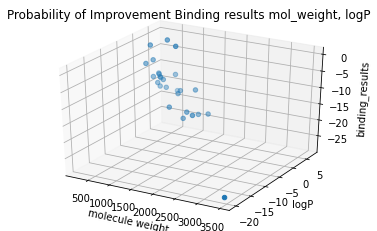

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

fig = plt.figure()

ax = fig.add_subplot(1,1,1, projection='3d')
#ax.xaxis.label('weight')
ax.set_title('Probability of Improvement Binding results mol_weight, logP')
x = x
y = y
z = z
img = ax.scatter(x, y, z,)
plt.xlabel('molecule weight', fontsize=10)
plt.ylabel('logP', fontsize= 10)
ax.set_zlabel('binding_results', fontsize = 10)

#plt.show()
plt.savefig('Pi_w_logP.png',dpi = 300)
plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

fig = plt.figure()

ax = fig.add_subplot(1,1,1, projection='3d')
#ax.xaxis.label('weight')
ax.set_title('Probability of Improvement Binding results mol_weight, hAcceptors')
x = x
y = y
z = z
img = ax.scatter(x, t, z,)
plt.xlabel('molecule weight', fontsize=10)
plt.ylabel('logP', fontsize= 10)
ax.set_zlabel('binding_results', fontsize = 10)

#plt.show()
plt.savefig('PI_w_hacc.png',dpi = 300)
plt.show()

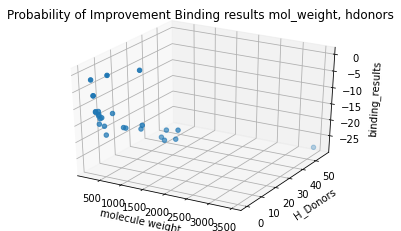

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

fig = plt.figure()

ax = fig.add_subplot(1,1,1, projection='3d')
#ax.xaxis.label('weight')
ax.set_title('Probability of Improvement Binding results mol_weight, hdonors')
x = x
y = y
z = z
img = ax.scatter(x, u, z,)
plt.xlabel('molecule weight', fontsize=10)
plt.ylabel('H_Donors', fontsize= 10)
ax.set_zlabel('binding_results', fontsize = 10)

#plt.show()
plt.savefig('PI_w_hdon.png',dpi = 300)
plt.show()

These plots clearly showed a convergence/clustering of the molecules properties

Unfortunately there is no convenient "pythonic" way to search for the drug properties. So I had to manually investigate PubChem and Drugbank and focussed on the derivatives of abarelix and ganirelix, evorolimus and acetyldigoxin, vintafolide, bivalirudin.
Setting Miltefosine as a reference molecule, I found that teverelix, model two bound best to the E9BAU8.0.apo target molecule.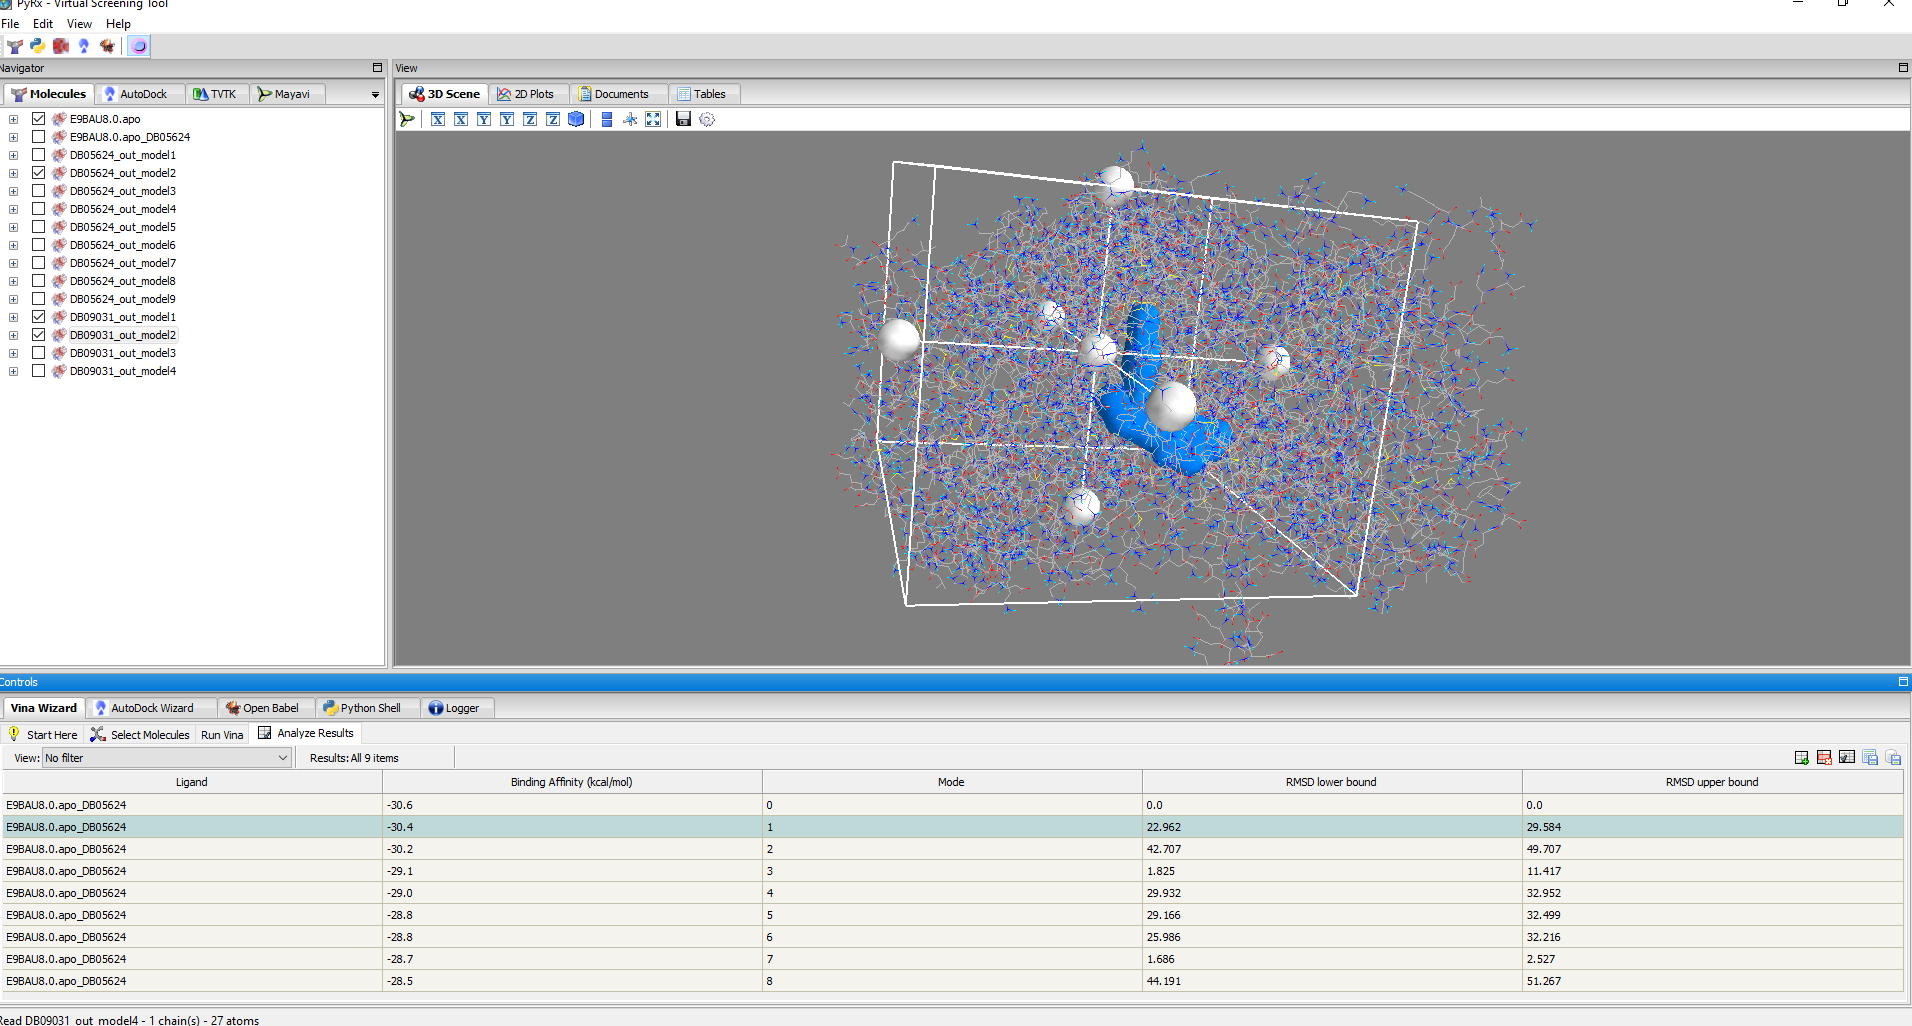

The following lines of code will verity my best submitted solution

In [ ]:
!cp /content/google_drive/MyDrive/Colab_Notebooks/Deep_Leila/deep_leishmaniasis_labour/Bayes_Opt/results/Best_molecules/DB05624_out_model2.pdb /content/
!cp /content/google_drive/MyDrive/Colab_Notebooks/Deep_Leila/deep_leishmaniasis_labour/Bayes_Opt/targets/E9BAU8.0.apo.pdb /content/

In [ ]:
#make sure every atom of the ligand is set to HETATM
!sed -i 's/ATOM/HETATM/g' /content/DB05624_out_model2.pdb 

In [ ]:
#concatenate them
!cat /content/E9BAU8.0.apo.pdb /content/DB05624_out_model2.pdb > /content/final_submission.pdb 

In [ ]:
!cmp --silent $/content/google_drive/MyDrive/Colab_Notebooks/Deep_Leila/deep_leishmaniasis_labour/Bayes_Opt/results/submissions/teve_e9_sub__1_.pdb $/content/final_submission.pdb || echo "files are different"

files are different


In [ ]:
!cp /content/final_submission.pdb /content/google_drive/MyDrive/Colab_Notebooks/Deep_Leila/deep_leishmaniasis_labour/Bayes_Opt/results/submissions

The files are indeed the identical. The only difference is that the #Remark statement of the Ligand is misplaced in line 17325 of the final_submission.pdb file and has to be edited.

-

-